# Feature Engineering, Feature Selection & Exploratory Data Analysis

In this step We're gonna to explore our features in order to create new and more significant features. Besides, We'll look for parterns that may help us to solve the challange and include these parterns in the model.

# 1) Setup

In [1]:
#Libs
import os
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv, find_dotenv
from haversine import haversine
from utils.features.stats import check_kruskal_wallis


In [2]:
# Env variables and data
load_dotenv(find_dotenv())
DATA_INPUT_PATH = os.getenv('DATA_PROCESSED_PATH')
DATA_TRAIN_NAME = 'train'
DATA_TEST_NAME = 'test'
# Data
df_orders_train = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TRAIN_NAME))
df_orders_test = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TEST_NAME))

# 2) Feature Engineering

## 2.1) Time Features

As We have the promised time, We can use information from It as a proxy to the time the order was made. Hence, We are  going to be able to extract hour, day, month, week, and all other characteristics about the time and provide them to the model to learn patterns about It and how those characteristics relates to total minutes.  

In [3]:
df_orders_train['hour'] = df_orders_train['promised_time'].apply(lambda x: x.hour)
df_orders_train['day'] = df_orders_train['promised_time'].apply(lambda x: x.dayofweek)
df_orders_train['month'] = df_orders_train['promised_time'].apply(lambda x: x.month)

## 2.2) Distance

We should calculate distance between store and consumer, so that We can have a clue about the time will take to complete the order.To acomplish this, We'll be using the Harvesine function of sklearn.

In [4]:
df_orders_train['distance_km'] = df_orders_train.apply(lambda x: haversine((x['lat_os'], x['lng_os']), 
                                                                          (x['lat_strb'], x['lng_strb'])), axis=1)

In [5]:
df_orders_train.columns

Index(['order_id', 'lat_os', 'lng_os', 'promised_time', 'on_demand',
       'shopper_id', 'store_branch_id', 'total_minutes', 'seniority',
       'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'store_id',
       'lat_strb', 'lng_strb', 'sum_kgs', 'sum_unities', 'n_distinct_items',
       'hour', 'day', 'month', 'distance_km'],
      dtype='object')

Before We proceed, I'll drop unuseful features (those that represent IDs, lat/long and promised time)


In [6]:
df_orders_train.drop(['order_id', 'lat_os', 'lng_os', 'promised_time', 
                      'shopper_id', 'store_branch_id', 'lat_strb', 'lng_strb', 'store_id'], axis=1, inplace=True)

# 3) Exploratory Data Analysis

Let's state some hypothesis and try to check them using statistics and visualization.

In [7]:
df_orders_train.columns

Index(['on_demand', 'total_minutes', 'seniority', 'found_rate',
       'picking_speed', 'accepted_rate', 'rating', 'sum_kgs', 'sum_unities',
       'n_distinct_items', 'hour', 'day', 'month', 'distance_km'],
      dtype='object')

## 3.1) General Questions

- How is total_minutes distributed ?

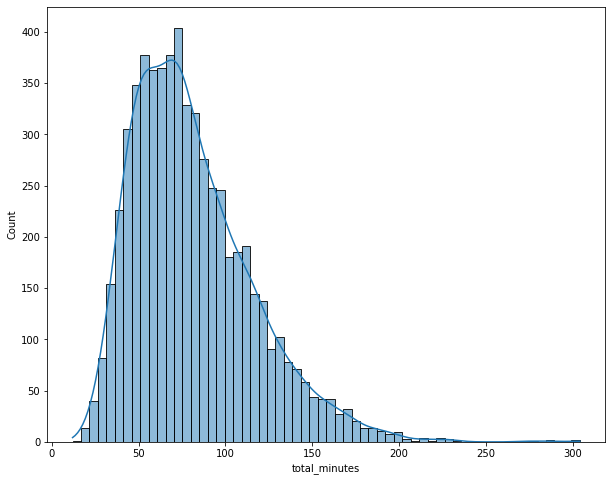

In [22]:
plt.figure(figsize=(10,8))
sns.histplot(df_orders_train['total_minutes'], kde=True)
plt.show()

In [8]:
df_orders_median_total_minutes_seniority = df_orders_train.groupby('seniority').median()[['total_minutes']].reset_index(level=0)

- How seniority is related to total minutes?

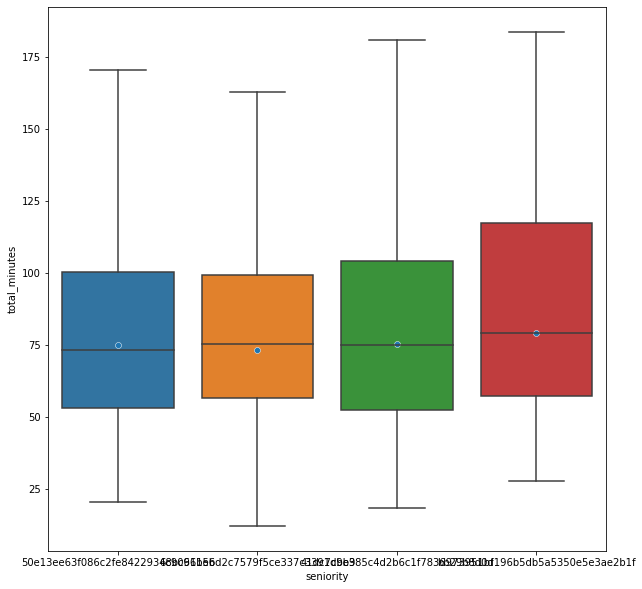

In [9]:
fig = plt.figure(figsize=(10,10))
sns.boxplot(y=df_orders_train['total_minutes'], x=df_orders_train['seniority'], showfliers=False)
sns.scatterplot(x=df_orders_median_total_minutes_seniority['seniority'], y=df_orders_median_total_minutes_seniority['total_minutes'])
plt.show()

It seems there are some subtle differences between median of distributions, though this difference can greater if We include other factors in this analysis, like number of items, distance and etc. To assure there is statistical significance in this result, We're gonna perform a Kruskal Wallis test to test for their medians.

In [10]:
df_orders_train['seniority'].unique()

array(['50e13ee63f086c2fe84229348bc91b5b',
       '6c90661e6d2c7579f5ce337c3391dbb9',
       '41dc7c9e385c4d2b6c1f7836973951bf',
       'bb29b8d0d196b5db5a5350e5e3ae2b1f'], dtype=object)

In [11]:
check_kruskal_wallis(df=df_orders_train, x='seniority', y='total_minutes')

H-statistic: 5.687785157420876
P-Value: 0.12782857411581117
Accept NULL hypothesis - No significant difference between groups.


- How picking speed is related to total minutes ?

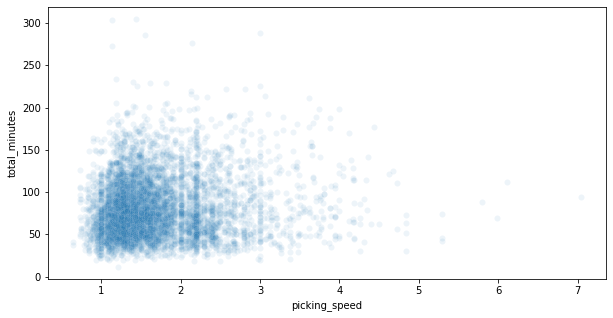

In [17]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x=df_orders_train['picking_speed'], 
                y=df_orders_train['total_minutes'],
                alpha=.08)
plt.show()

It seems there is some positive association between picking_speed and total_minutes.

- Is there a specific hour in the day that seems to be a bottleneck ?

- Do orders on demand tend to get faster ? 

- How sum_kgs, sum_unities and n_distinct_items relate to total minutes?

- How the days of the week affect total minutes?

- How the distance is related to total minutes ? Is this relationship affect by number of items?

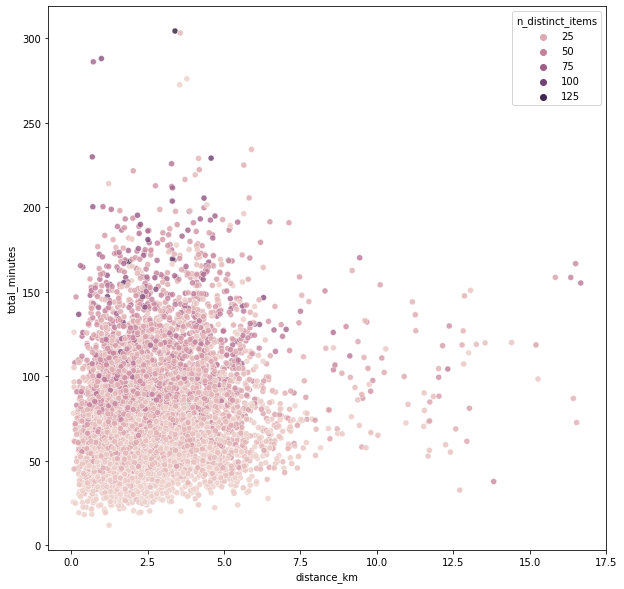

In [29]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=df_orders_train['distance_km'], 
                y=df_orders_train['total_minutes'],
                hue=df_orders_train['n_distinct_items'],
                alpha=.8)
plt.show()

## 3.2) Correlation and Associations

# 4) Feature Selection